# Call Spread with highest probability of profit (PoP)

Call spreads are [vertical spreads](https://www.investopedia.com/terms/v/verticalspread.asp), i.e., two-legged options strategies where the trader buys a call and simultaneously sells another call, both with same expiration but different strikes.

Vertical spreads offer a downside risk floor, contributing to effective risk management, while also capping potential gains.

In this notebook, we conduct a search for the call spread with the highest probability of profit by considering all possible pairs of strikes, with and without a constraint. The underlying asset in focus is Microsoft stock, which was trading at 342.97 on November 22, 2021. The strike, bid price, and ask price of call options expiring on December 17, 2021, are sourced from a CSV file.

For further details on this study, refer to [this article on Medium.com](https://medium.com/@rgaveiga/python-for-options-trading-1-selecting-a-call-spread-with-the-highest-probability-of-profit-8e61c9d325d6)

**Caveat: Options are very risky derivatives and, like any other type of financial vehicle, trading options requires due diligence. Transactions shown as examples of trading strategies with options in this notebook are not recommendations.**

In [1]:
from __future__ import print_function

import datetime as dt

import matplotlib.pyplot as plt
import pandas as pd
from numpy import zeros

from optionlab import Inputs, run_strategy

%matplotlib inline

In [2]:
stock_price = 342.97
volatility = 0.18
start_date = dt.date(2021, 11, 22)
target_date = dt.date(2021, 12, 17)
interest_rate = 0.001
min_stock = 0.0
max_stock = stock_price + round(stock_price * 0.5, 2)

In [3]:
df = pd.read_csv("msft_22-November-2021.csv")
chain = []

for i, _ in enumerate(df["Expiration"]):
    if (
        df["Expiration"][i] == target_date.strftime("%Y-%m-%d")
        and df["Type"][i] == "call"
    ):
        chain.append([df["Strike"][i], df["Bid"][i], df["Ask"][i]])

### Unconstrained:

In [4]:
def get_highest_pop():
    maxpop = 0.0

    best_strategy = None
    for i in range(len(chain) - 1):
        for j in range(i + i, len(chain)):
            for k in (("sell", "buy"), ("buy", "sell")):
                if k[0] == "sell":
                    premium = [chain[i][1], chain[j][2]]
                else:
                    premium = [chain[i][2], chain[j][1]]

                strategy = [
                    {
                        "type": "call",
                        "strike": chain[i][0],
                        "premium": premium[0],
                        "n": 100,
                        "action": k[0],
                    },
                    {
                        "type": "call",
                        "strike": chain[j][0],
                        "premium": premium[1],
                        "n": 100,
                        "action": k[1],
                    },
                ]

                inputs = Inputs(
                    stock_price=stock_price,
                    start_date=start_date,
                    target_date=target_date,
                    volatility=volatility,
                    interest_rate=interest_rate,
                    min_stock=min_stock,
                    max_stock=max_stock,
                    strategy=strategy,
                )

                out = run_strategy(inputs)

                if maxpop < out.probability_of_profit:
                    maxpop = out.probability_of_profit
                    best_strategy = strategy

    return best_strategy

In [5]:
%%time
best_strategy = get_highest_pop()

CPU times: total: 39.8 s
Wall time: 42.4 s


In [6]:
print(best_strategy)

[{'type': 'call', 'strike': np.float64(145.0), 'premium': np.float64(198.05), 'n': 100, 'action': 'buy'}, {'type': 'call', 'strike': np.float64(305.0), 'premium': np.float64(38.1), 'n': 100, 'action': 'sell'}]


In [7]:
inputs = Inputs(
    stock_price=stock_price,
    start_date=start_date,
    target_date=target_date,
    volatility=volatility,
    interest_rate=interest_rate,
    min_stock=min_stock,
    max_stock=max_stock,
    strategy=best_strategy,
)

out = run_strategy(inputs)

In [8]:
print(f"Strategy cost: {out.strategy_cost:.2f}")
print(f"Maximum loss: {abs(out.minimum_return_in_the_domain):.2f}")
print(f"Maximum profit: {out.maximum_return_in_the_domain:.2f}")
print("Profitable stock price range:")

for low, high in out.profit_ranges:
    print(f"      {low:.2f} ---> {high:.2f}")

print(f"Probability of Profit (PoP): {out.probability_of_profit * 100.0:.1f}")

Strategy cost: -15995.00
Maximum loss: 15995.00
Maximum profit: 5.00
Profitable stock price range:
      304.96 ---> inf
Probability of Profit (PoP): 99.1


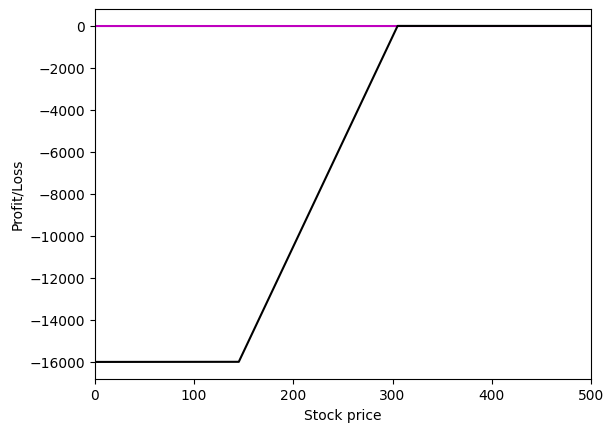

In [9]:
s, pl_total = out.data.stock_price_array, out.data.strategy_profit
zeroline = zeros(s.shape[0])
plt.xlabel("Stock price")
plt.ylabel("Profit/Loss")
plt.xlim(0, 500)
plt.plot(s, zeroline, "m-")
plt.plot(s, pl_total, "k-")

### Constrained (maximum profit/minimum loss ratio greater than or equal to 1):

In [10]:
def get_highest_pop():
    maxpop = 0.0

    best_strategy = None
    for i in range(len(chain) - 1):
        for j in range(i + i, len(chain)):
            for k in (("sell", "buy"), ("buy", "sell")):
                if k[0] == "sell":
                    premium = [chain[i][1], chain[j][2]]
                else:
                    premium = [chain[i][2], chain[j][1]]

                strategy = [
                    {
                        "type": "call",
                        "strike": chain[i][0],
                        "premium": premium[0],
                        "n": 100,
                        "action": k[0],
                    },
                    {
                        "type": "call",
                        "strike": chain[j][0],
                        "premium": premium[1],
                        "n": 100,
                        "action": k[1],
                    },
                ]

                inputs = Inputs(
                    stock_price=stock_price,
                    start_date=start_date,
                    target_date=target_date,
                    volatility=volatility,
                    interest_rate=interest_rate,
                    min_stock=min_stock,
                    max_stock=max_stock,
                    strategy=strategy,
                )

                out = run_strategy(inputs)

                if (
                    out.maximum_return_in_the_domain
                    / abs(out.minimum_return_in_the_domain)
                    >= 1.0
                ):
                    if maxpop < out.probability_of_profit:
                        maxpop = out.probability_of_profit
                        best_strategy = strategy

    return best_strategy

In [11]:
%%time
best_strategy = get_highest_pop()

CPU times: total: 39.5 s
Wall time: 42.3 s


In [12]:
print(best_strategy)

[{'type': 'call', 'strike': np.float64(260.0), 'premium': np.float64(83.0), 'n': 100, 'action': 'buy'}, {'type': 'call', 'strike': np.float64(430.0), 'premium': np.float64(0.07), 'n': 100, 'action': 'sell'}]


In [13]:
inputs = Inputs(
    stock_price=stock_price,
    start_date=start_date,
    target_date=target_date,
    volatility=volatility,
    interest_rate=interest_rate,
    min_stock=min_stock,
    max_stock=max_stock,
    strategy=best_strategy,
)

out = run_strategy(inputs)

In [14]:
print(f"Strategy cost: {out.strategy_cost:.2f}")
print(f"Maximum loss: {abs(out.minimum_return_in_the_domain):.2f}")
print(f"Maximum profit: {out.maximum_return_in_the_domain:.2f}")
print("Profitable stock price range:")

for low, high in out.profit_ranges:
    print(f"      {low:.2f} ---> {high:.2f}")

print(f"Probability of Profit (PoP): {out.probability_of_profit * 100.0:.1f}")

Strategy cost: -8293.00
Maximum loss: 8293.00
Maximum profit: 8707.00
Profitable stock price range:
      342.94 ---> inf
Probability of Profit (PoP): 49.1


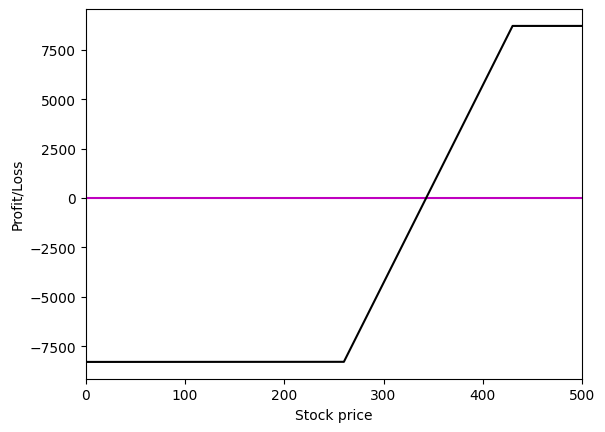

In [15]:
s, pl_total = out.data.stock_price_array, out.data.strategy_profit
zeroline = zeros(s.shape[0])
plt.xlabel("Stock price")
plt.ylabel("Profit/Loss")
plt.xlim(0, 500)
plt.plot(s, zeroline, "m-")
plt.plot(s, pl_total, "k-")